# Using Data Science for Bad Decision-Making

You will probably be intrigued by the title of this post. In this notebook Ido not want to present a fancy data science trick or to test a novel technique. I would simply like to tell a story. A story about how data science can be used to make bad decisions. "How can this be?" you might ask. Everyone has been saying that data is the way to unlock insights to gain a competitive advantage. Well, it is true. But it is also true that data can be used decisions that can actually hurt your business. There are many possible reasons you could think of (and you might even have experienced some of them). The story I am about to tell won't be about bad algorithms or bad data. It will be about thinking about data as simply

$$
\text{data in} \rightarrow \text{ML model} \rightarrow \text{data out} \rightarrow \text{decision}
$$

instead of thinking about the data generating process. In other words, it will be about not thinking about **causality**. 

### The Business Problem

The story begins in a fast paced startup. The company is growing fast and the marketing team is looking for ways to increase the sales from existing customers by making them buy more. The main idea is to unlock the potential of the customer based through incentives, in this case a discount. We of course want to measure the effect of the discount on the customer's behavior. Still, they do not want to waste money giving discounts to users which are not valuable. As always, it is about return on investment (ROI). Without going into specifics about the nature of the discount, it has been designed to provide a positive return on investment if the customer buys more than $1\$$ as a result of the discount. How can we measure the effect of the discount and make sure our experiment has a positive ROI? The marketing team came up with the following strategy:

- Select a sample of existing customers from the same cohort.
- Set a test window of 1 month.
- Look into the historical data of web visits from the last month. The hypothesis is that web visits are a good proxy for the customer's interest in the product.
- For customers with a high number of web visits, send them a discount. There will be a hold out group which will not receive the discount within the potential valuable customers based on the number of web visits. For customers with a low number of web visits, do not send them a discount (the marketing team wants to report a positive ROI, so they do not want to waste money on customers which are not valuable). Still, they want to use them to measure the effect of the discount.
- We also want to use the results of the test to cluster tag *loyal* customers. These are customers which got a discount (since they showed potential interest in the product) and customers with exceptional sales numbers even if they did not get a discount. The idea is to use this information to target them in the future if the discount strategy is positive.

### The Data

The team collected data from the experiment above and asked the data science team to analyze it and provide insights. In particular they want to know if they should keep the discount strategy. The data consists of the following fields:
- `visits`: Number of visits to the website during the test window.
- `discount`: Whether the customer received a discount or not.
- `is_loyal`: Whether the customer is loyal or not according to the definition above.
- `sales`: Sales in $\$$ during the test window.

### The Analysis

Now that the context, objectives and data are clear, let's look into the story about a relatively innocent analysis which turn out to be a pain and whose outcome and final decision was not the best one. But hey, do not worry, we will learn from it!

---

## Prepare Notebook

We want to make sure every component is reproducible so that the outcomes are not affected by pure randomness. We will set the random seed for the notebook and import the necessary libraries.

In [2]:
import arviz as az
import bambi as bmb
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed: int = sum(map(ord, "causality"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


In [96]:
data = pd.read_csv("../data/sales_dag.csv")

data.head()


,visits,discount,is_loyal,sales,sales_per_visit
0,12,0,0,13.348302,1.112359
1,26,1,1,21.701250,0.834663
2,13,0,0,14.700405,1.130800
3,24,0,0,20.377336,0.849056
4,14,0,0,12.633725,0.902409


In [97]:
data["discount"].value_counts() / len(data)

discount
1    0.74
0    0.26
Name: count, dtype: float64

In [98]:
data["is_loyal"].value_counts() / len(data)

is_loyal
1    0.75
0    0.25
Name: count, dtype: float64

In [99]:
pd.crosstab(data["discount"], data["is_loyal"])

is_loyal,0,1
discount,,
0,175,7
1,0,518


In [100]:
data.query("discount == 0 and is_loyal == 1")


,visits,discount,is_loyal,sales,sales_per_visit
49,33,0,1,27.790644,0.842141
104,29,0,1,26.217525,0.904053
204,33,0,1,28.311111,0.857912
280,29,0,1,27.581146,0.951074
365,33,0,1,28.081634,0.850959
545,27,0,1,26.255330,0.972420
566,33,0,1,31.721689,0.961263


In [101]:
data.groupby(["discount"]).agg({"sales": "mean"})


,sales
discount,
0,15.848788
1,20.647938


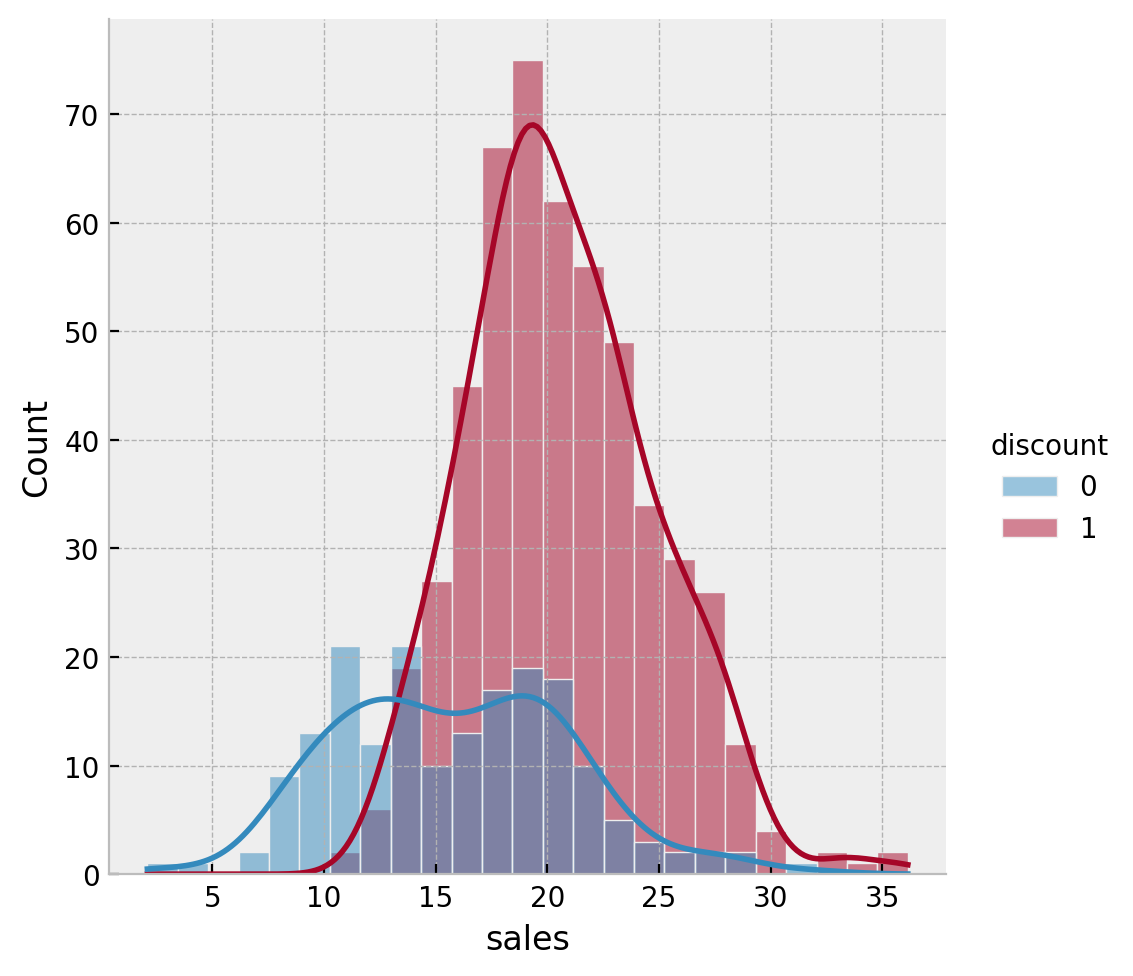

In [102]:
g = sns.displot(data=data, x="sales", hue="discount", kde=True)


In [103]:
(
    data.query("discount == 1")["sales"].mean()
    - data.query("discount == 0")["sales"].mean()
)

4.799150094279289

In [104]:
data.groupby(["discount"]).agg({"sales_per_visit": "mean"})


,sales_per_visit
discount,
0,0.861243
1,0.938293


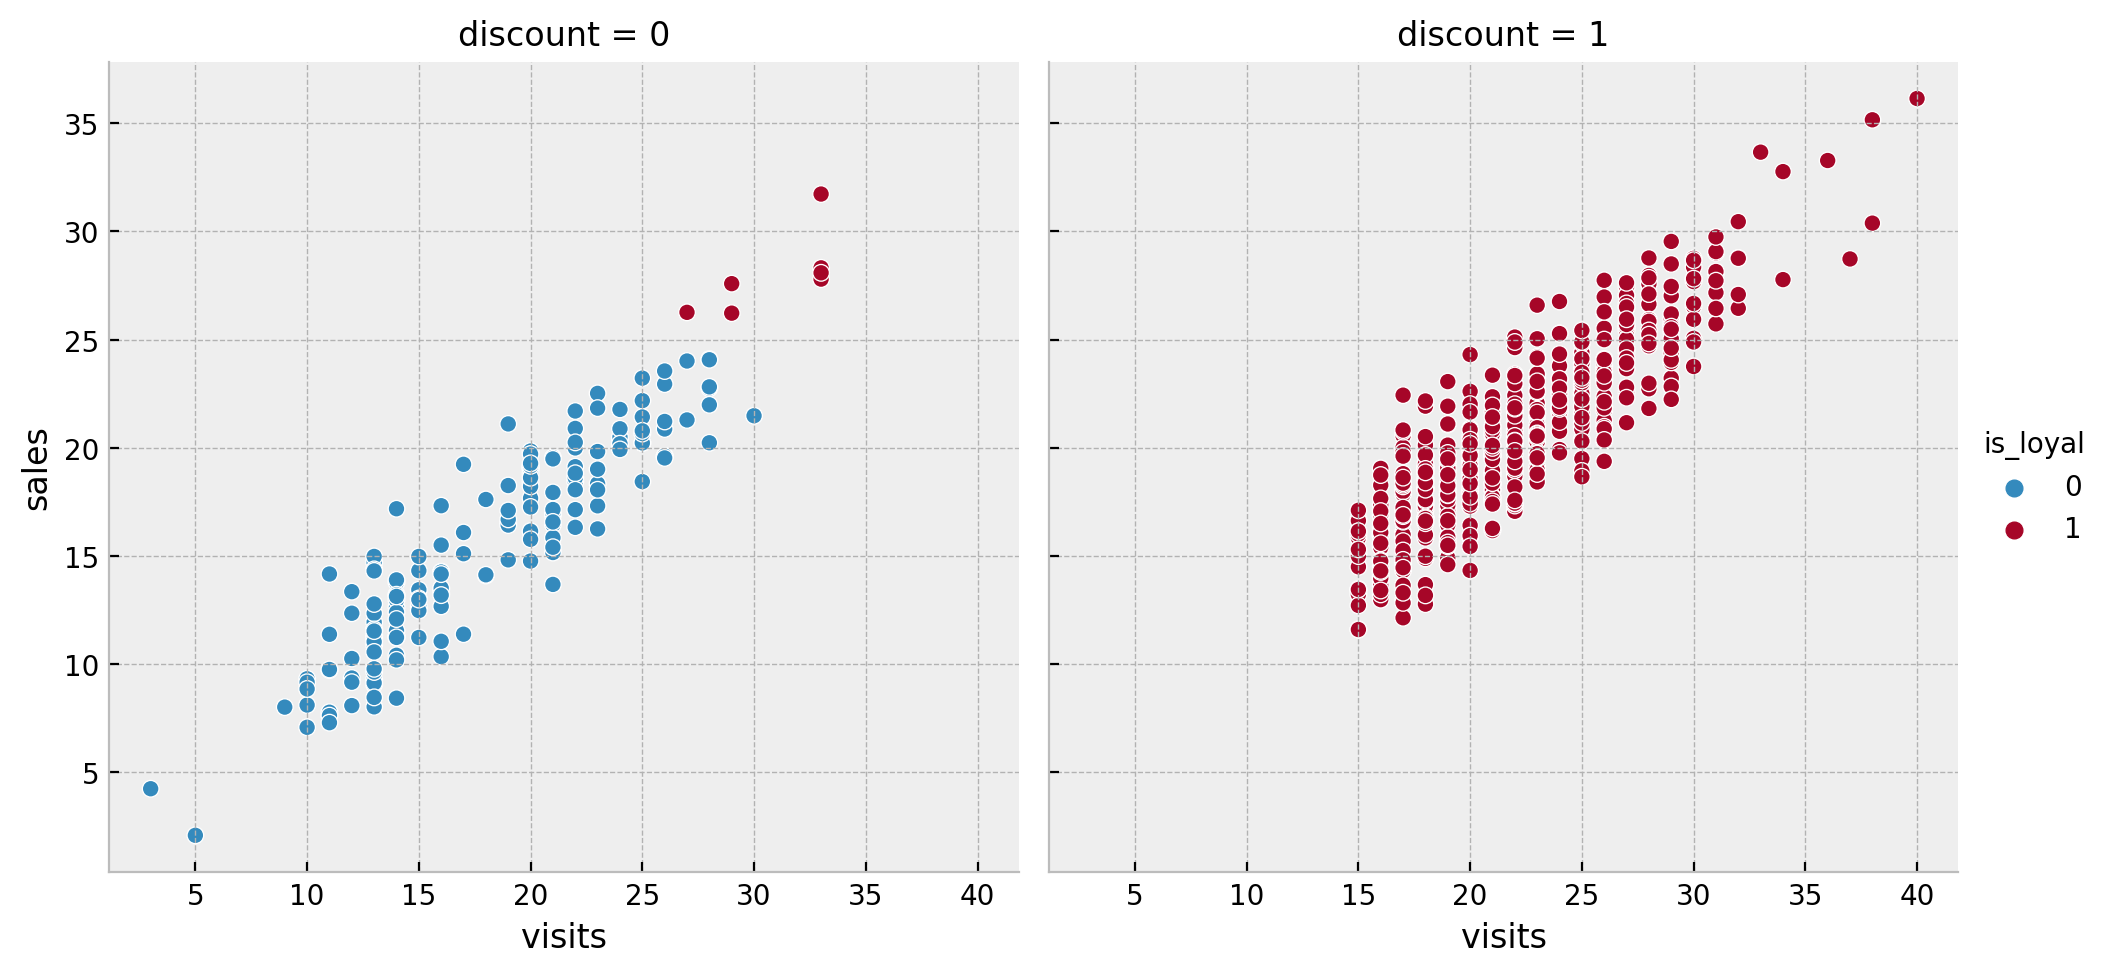

In [105]:
sns.relplot(data=data, x="visits", y="sales", hue="is_loyal", col="discount")


In [106]:
data.groupby(["is_loyal", "discount"]).agg({"sales": np.mean})


sales
is_loyal discount           
0        0         15.362973
1        0         27.994154
         1         20.647938

Text(0.5, 1.05, 'Sales distribution by discount and loyalty')

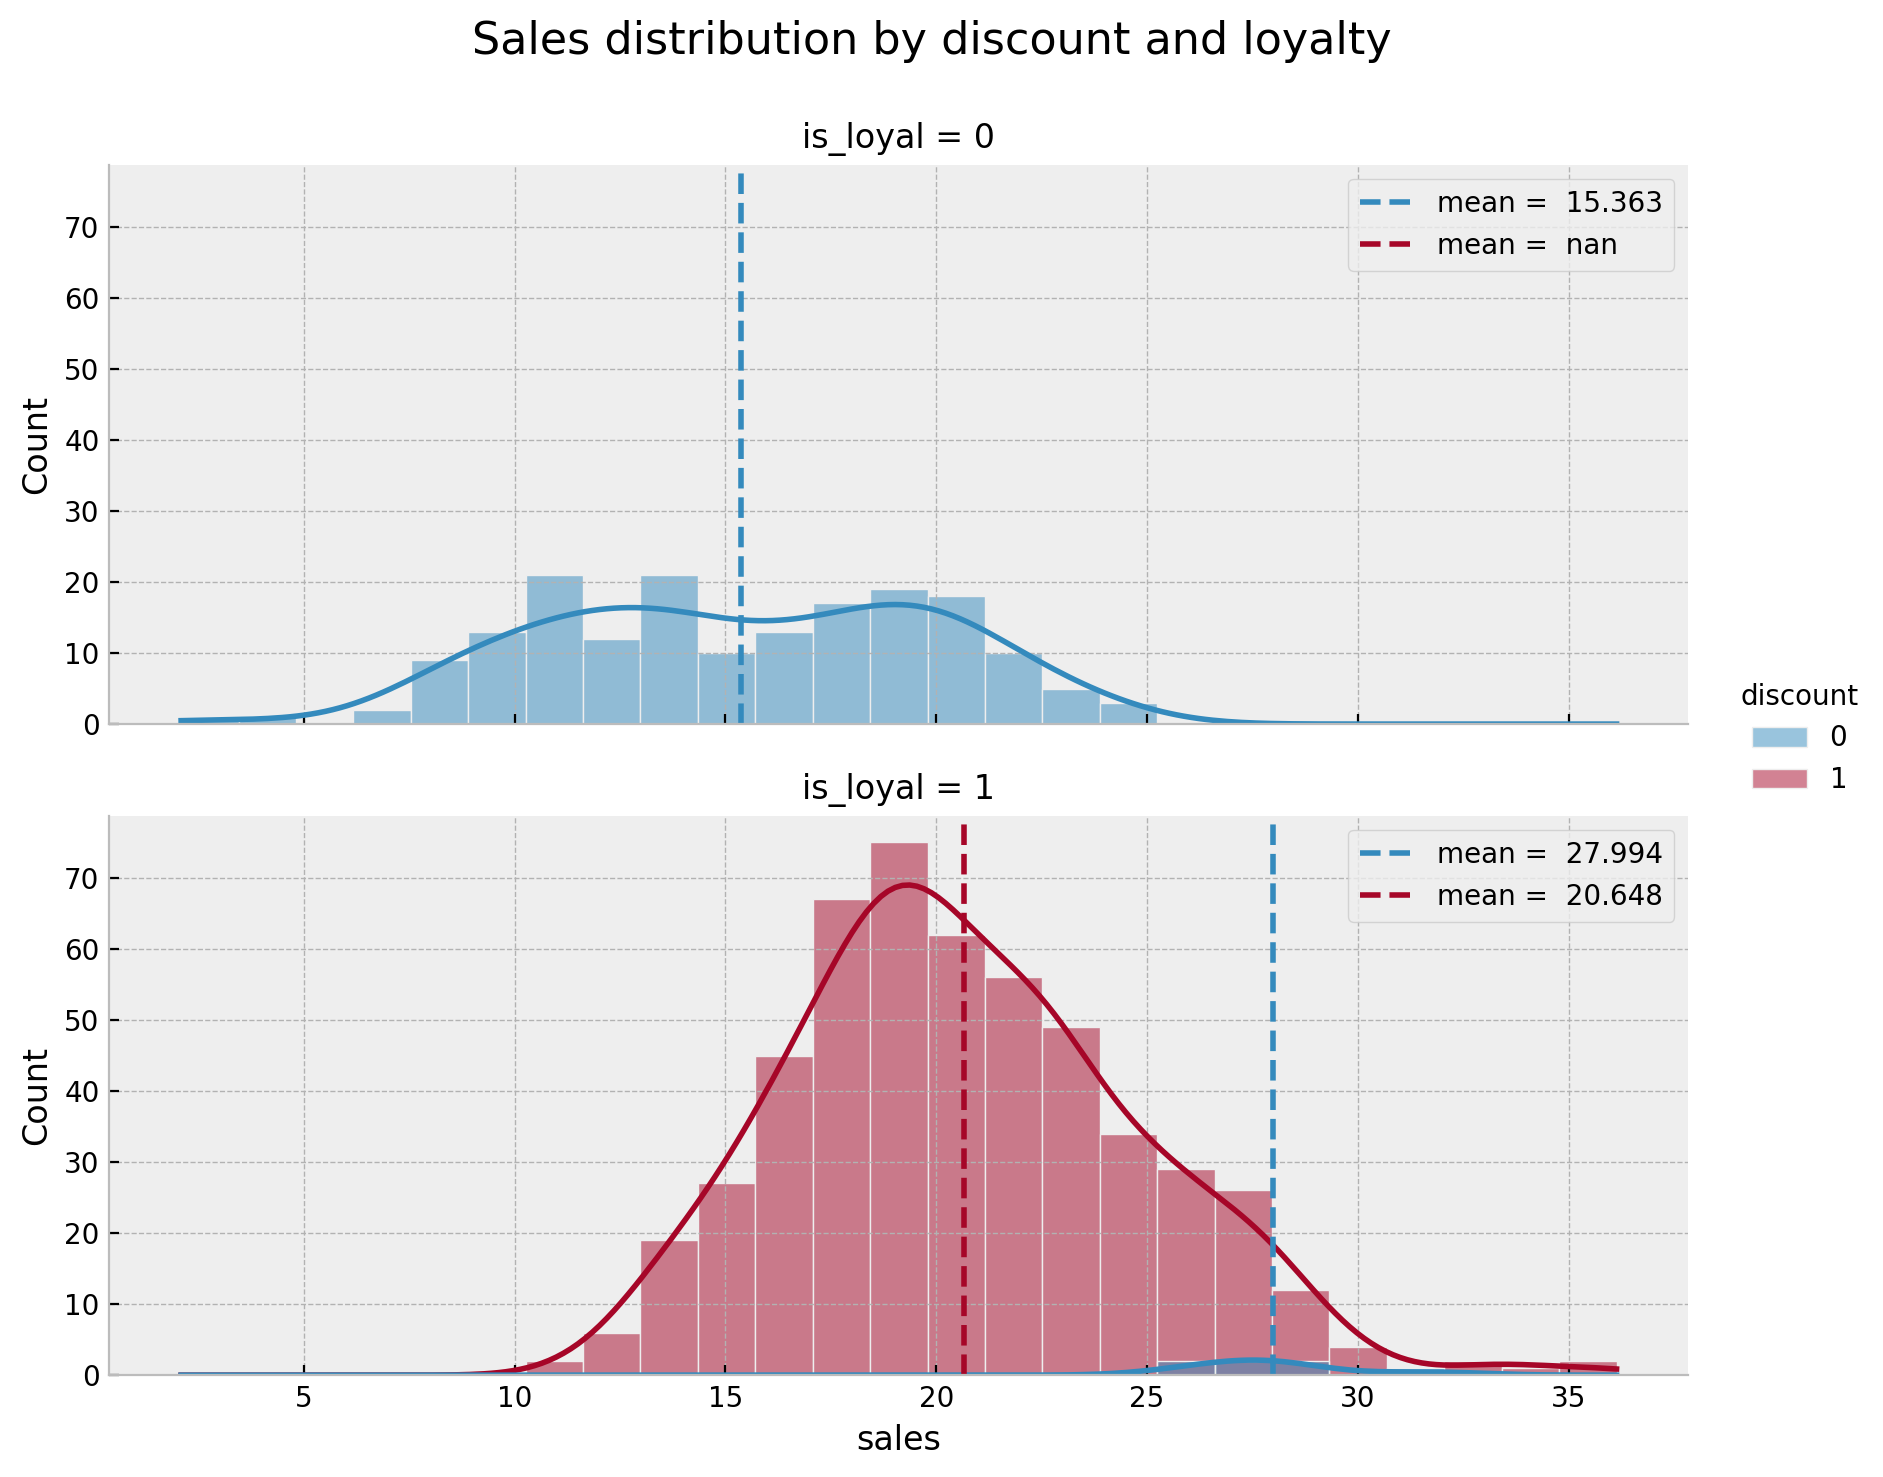

In [107]:
g = sns.displot(
    data=data,
    x="sales",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales"].mean()
        ax.axvline(
            x=df.query(f"discount == {discount}")["sales"].mean(),
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle("Sales distribution by discount and loyalty", y=1.05, fontsize=16)


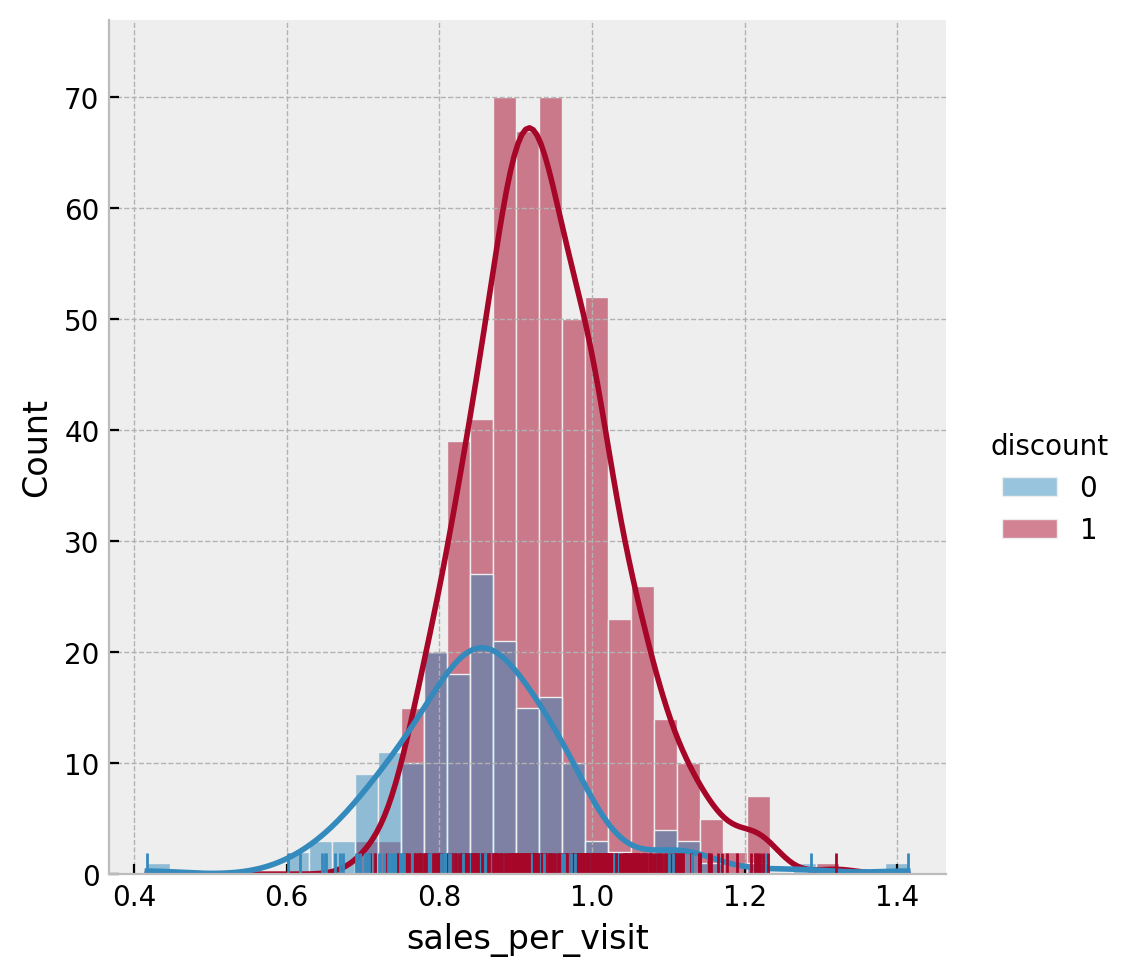

In [108]:
g = sns.displot(data=data, x="sales_per_visit", hue="discount", kde=True, rug=True)


Text(0.5, 1.05, 'Sales per visit distribution by discount and loyalty')

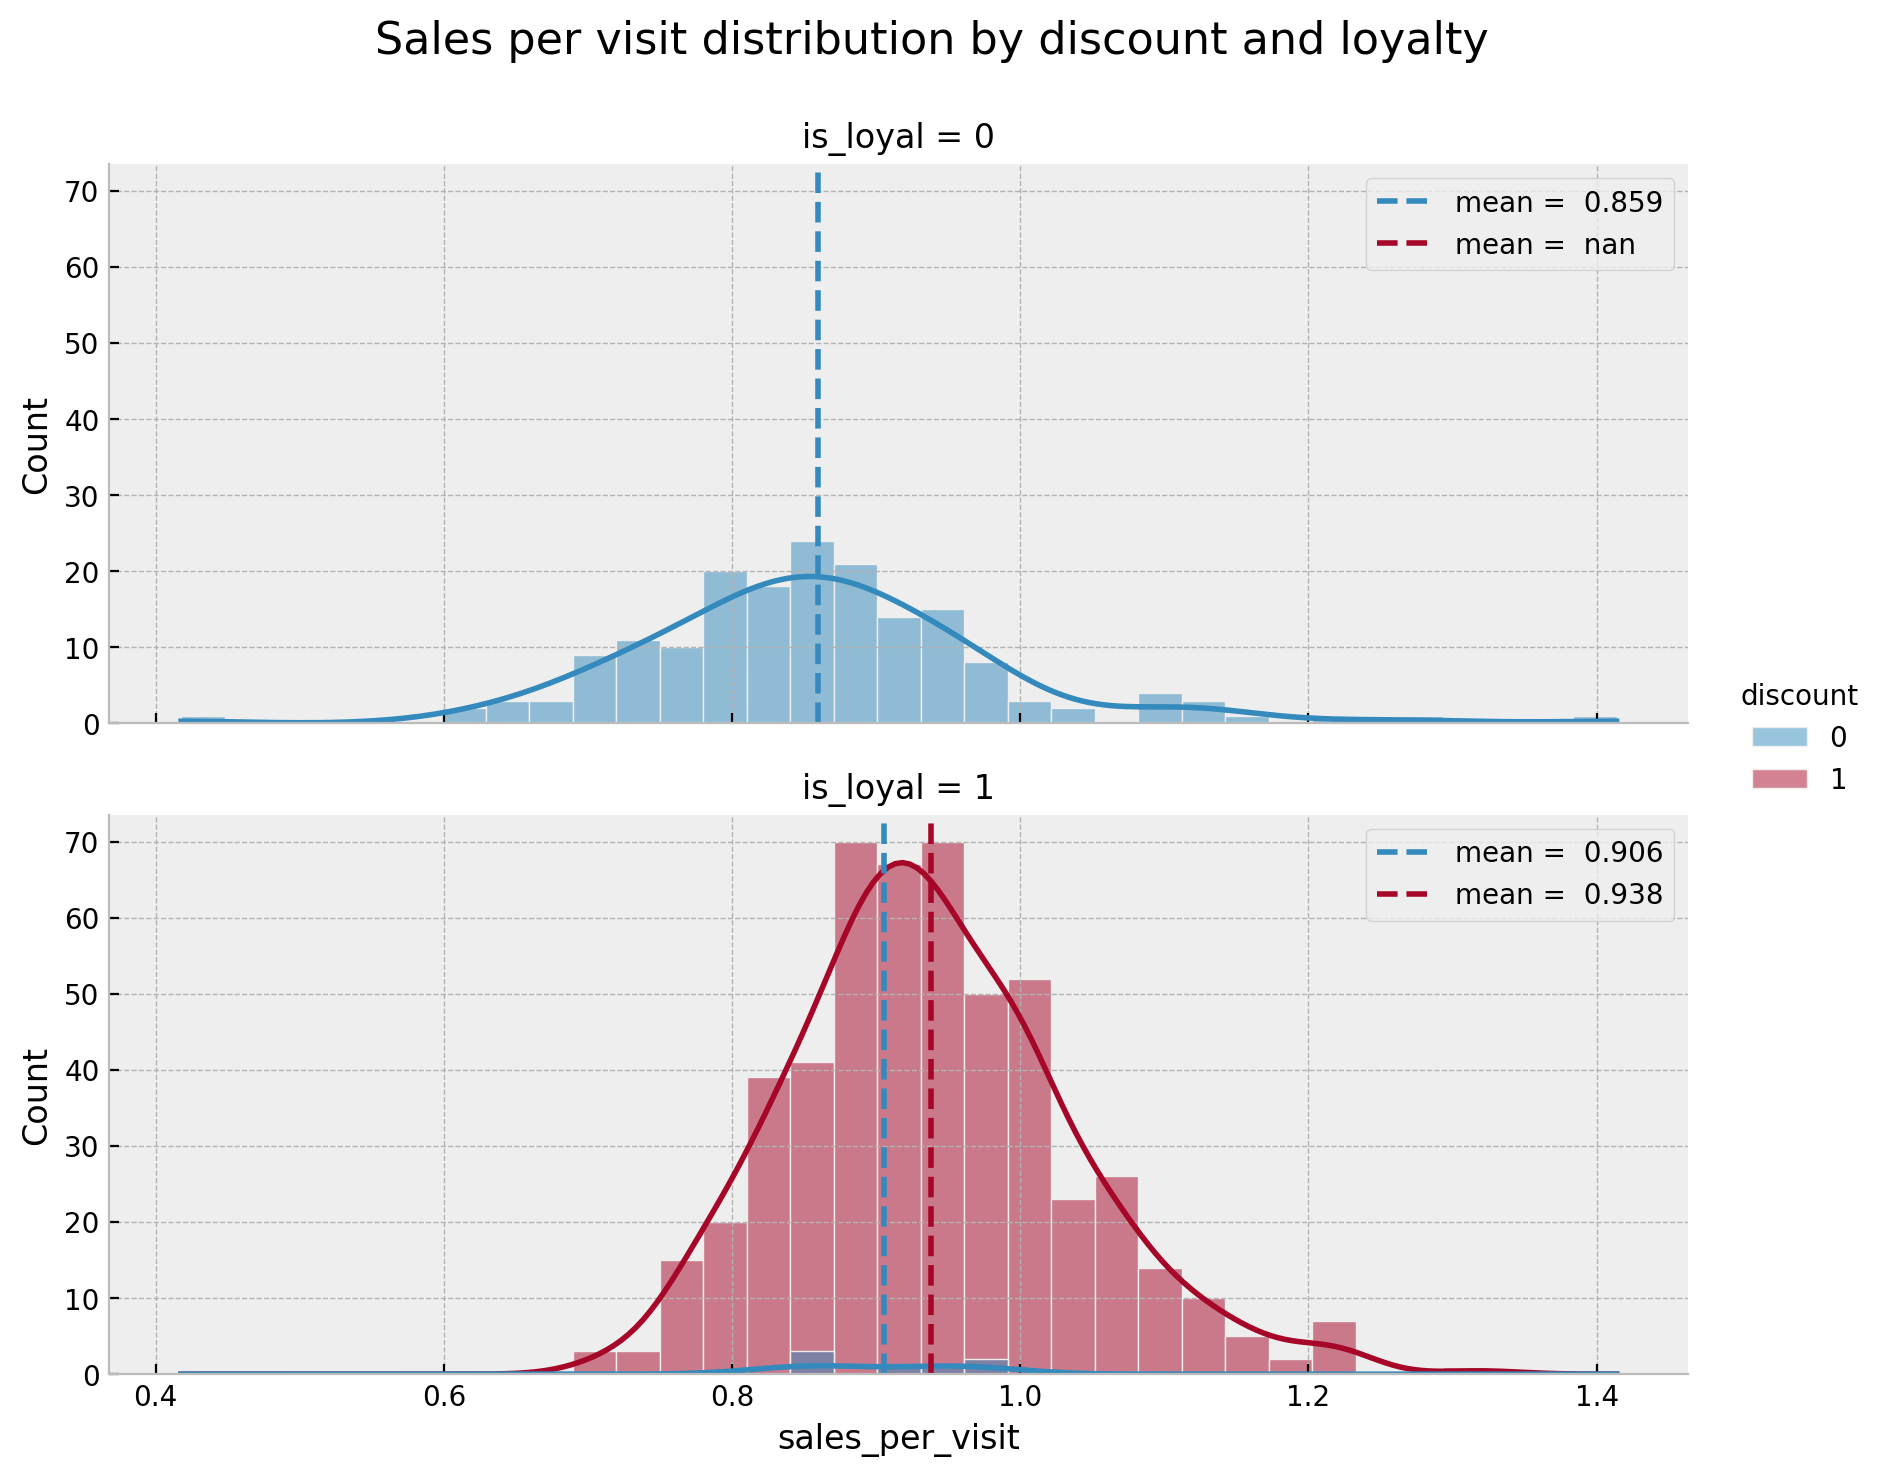

In [109]:
g = sns.displot(
    data=data,
    x="sales_per_visit",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales_per_visit"].mean()
        ax.axvline(
            x=mean,
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle(
    "Sales per visit distribution by discount and loyalty", y=1.05, fontsize=16
)

[Text(0.5, 1.0, 'ML Model - Actual vs Predicted Sales'),
 Text(0.5, 0, 'Actual'),
 Text(0, 0.5, 'Predicted')]

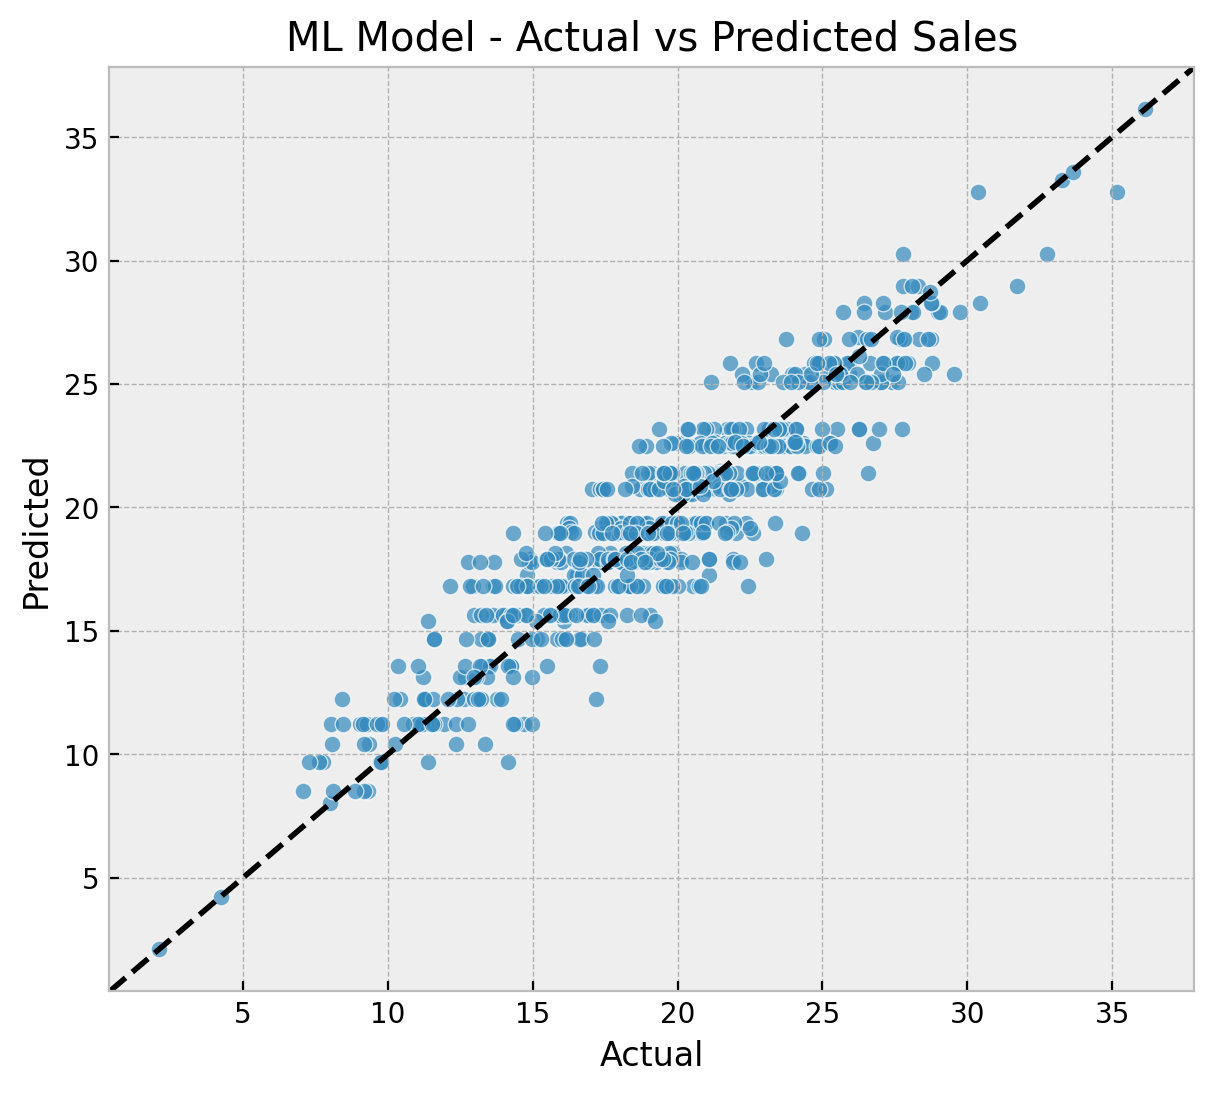

In [110]:
numeric_features = ["visits"]
categorical_features = ["discount", "is_loyal"]
features = numeric_features + categorical_features

X = data.assign(
    discount=lambda x: pd.Categorical(values=x["discount"], categories=[0, 1]),
    is_loyal=lambda x: pd.Categorical(values=x["is_loyal"], categories=[0, 1]),
).filter(items=features)

y = data["sales"].to_numpy()

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV


ml_model = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=seed),
    param_distributions=dict(
        learning_rate=uniform(loc=0.01, scale=0.1),
        n_estimators=randint(low=100, high=1_000),
        max_depth=randint(low=3, high=9),
    ),
    cv=8,
    n_iter=12,
    random_state=seed,
)

ml_model.fit(X=X, y=y)


y_pred = ml_model.predict(X=X)

fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(x=y, y=y_pred, color="C0", alpha=0.7, ax=ax)
ax.axline(xy1=(10, 10), slope=1, color="black", linestyle="--")
ax.set(
    title="ML Model - Actual vs Predicted Sales", xlabel="Actual", ylabel="Predicted"
)


Text(0.5, 1.05, 'ML Model - Partial Dependence Plots')

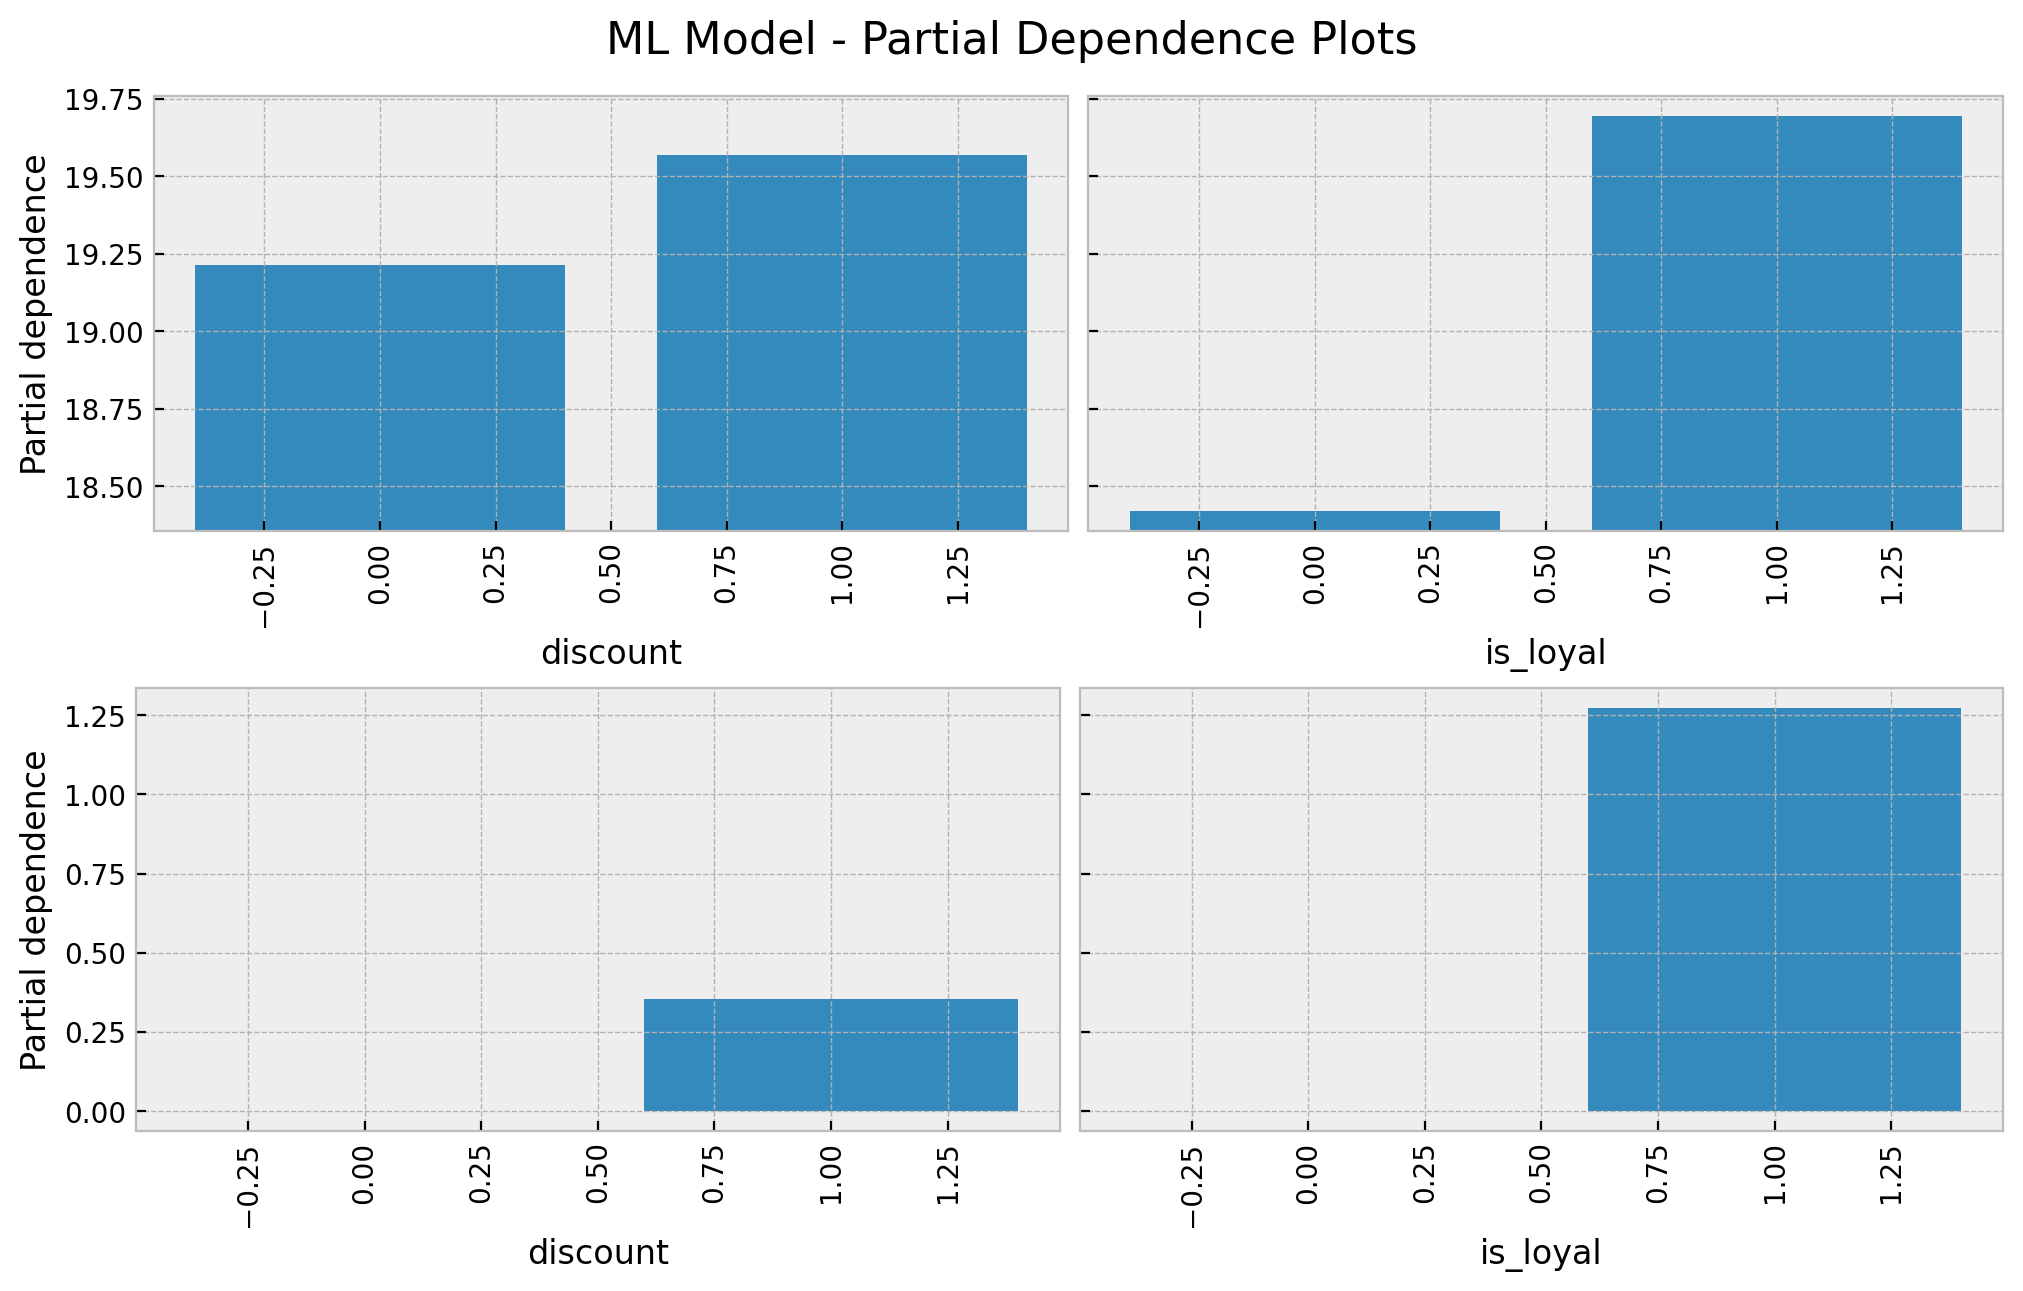

In [111]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)

for b in [False, True]:
    PartialDependenceDisplay.from_estimator(
        estimator=ml_model,
        X=X,
        features=categorical_features,
        categorical_features=categorical_features,
        centered=b,
        random_state=seed,
        ax=ax[int(b)],
    )
fig.suptitle("ML Model - Partial Dependence Plots", y=1.05, fontsize=16)

In [112]:
complete_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=10, sigma=3),
    "visits": bmb.Prior("Normal", mu=1, sigma=3),
    "discount": bmb.Prior("Normal", mu=0, sigma=3),
    "is_loyal": bmb.Prior("Normal", mu=0, sigma=3),
    "sigma": bmb.Prior("Exponential", lam=1 / 3),
}

complete_model = bmb.Model(
    formula="sales ~ discount + visits + is_loyal",
    data=data,
    family="gaussian",
    link="identity",
    priors=complete_model_priors,
)

complete_model


       Formula: sales ~ discount + visits + is_loyal
        Family: gaussian
          Link: mu = identity
  Observations: 700
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 10.0, sigma: 3.0)
            discount ~ Normal(mu: 0.0, sigma: 3.0)
            visits ~ Normal(mu: 1.0, sigma: 3.0)
            is_loyal ~ Normal(mu: 0.0, sigma: 3.0)
        
        Auxiliary parameters
            sales_sigma ~ Exponential(lam: 0.3333)

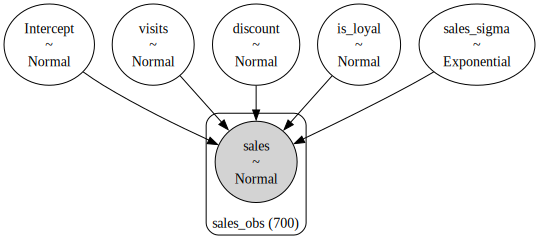

In [113]:
complete_model.build()
complete_model.graph()

In [114]:
complete_model_idata = complete_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.203958
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:06.245869
Transforming variables...
Transformation time =  0:00:00.033135


In [115]:
az.summary(data=complete_model_idata)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.107,0.309,0.532,1.696,0.002,0.002,16161.0,14515.0,1.0
discount,-0.195,0.697,-1.487,1.132,0.007,0.005,8859.0,10788.0,1.0
visits,0.793,0.015,0.764,0.821,0.000,0.000,15272.0,13202.0,1.0
is_loyal,2.176,0.718,0.825,3.513,0.008,0.005,8743.0,10471.0,1.0
sales_sigma,1.892,0.052,1.794,1.989,0.000,0.000,15153.0,12706.0,1.0


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Complete Model - Trace')

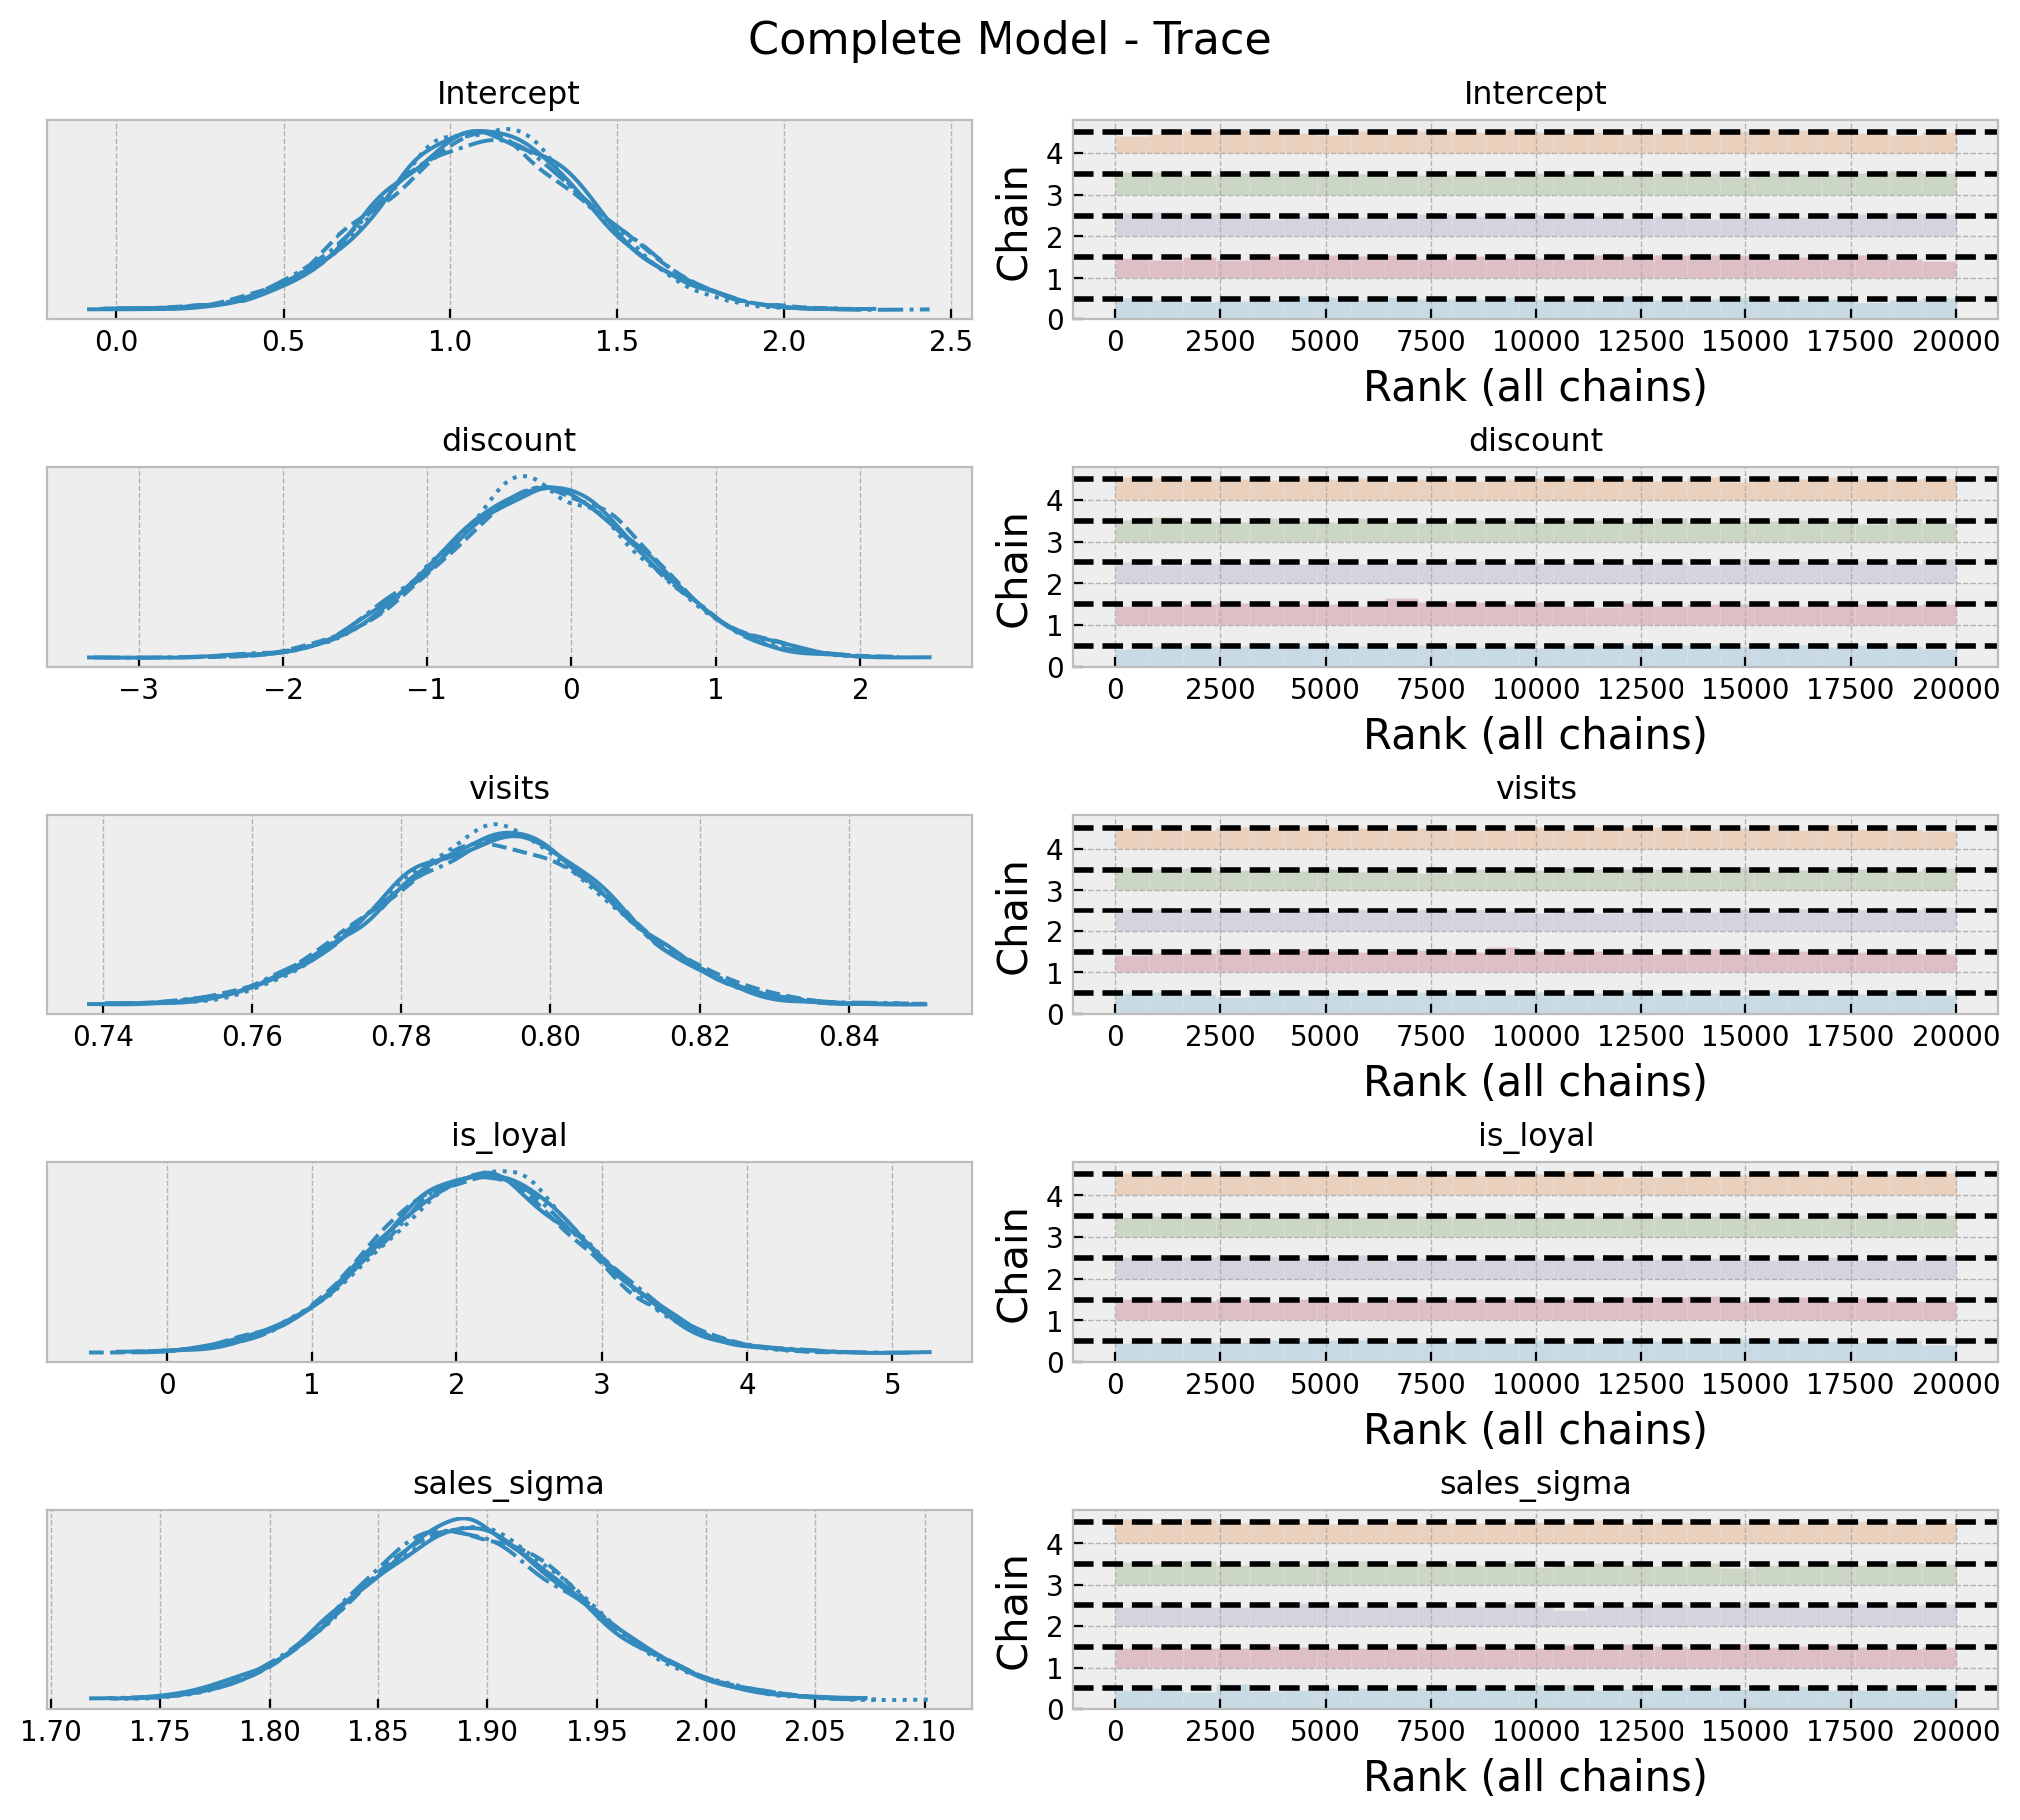

In [116]:
axes = az.plot_trace(
    data=complete_model_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Complete Model - Trace", fontsize=16)

<AxesSubplot:title={'center':'discount'}>

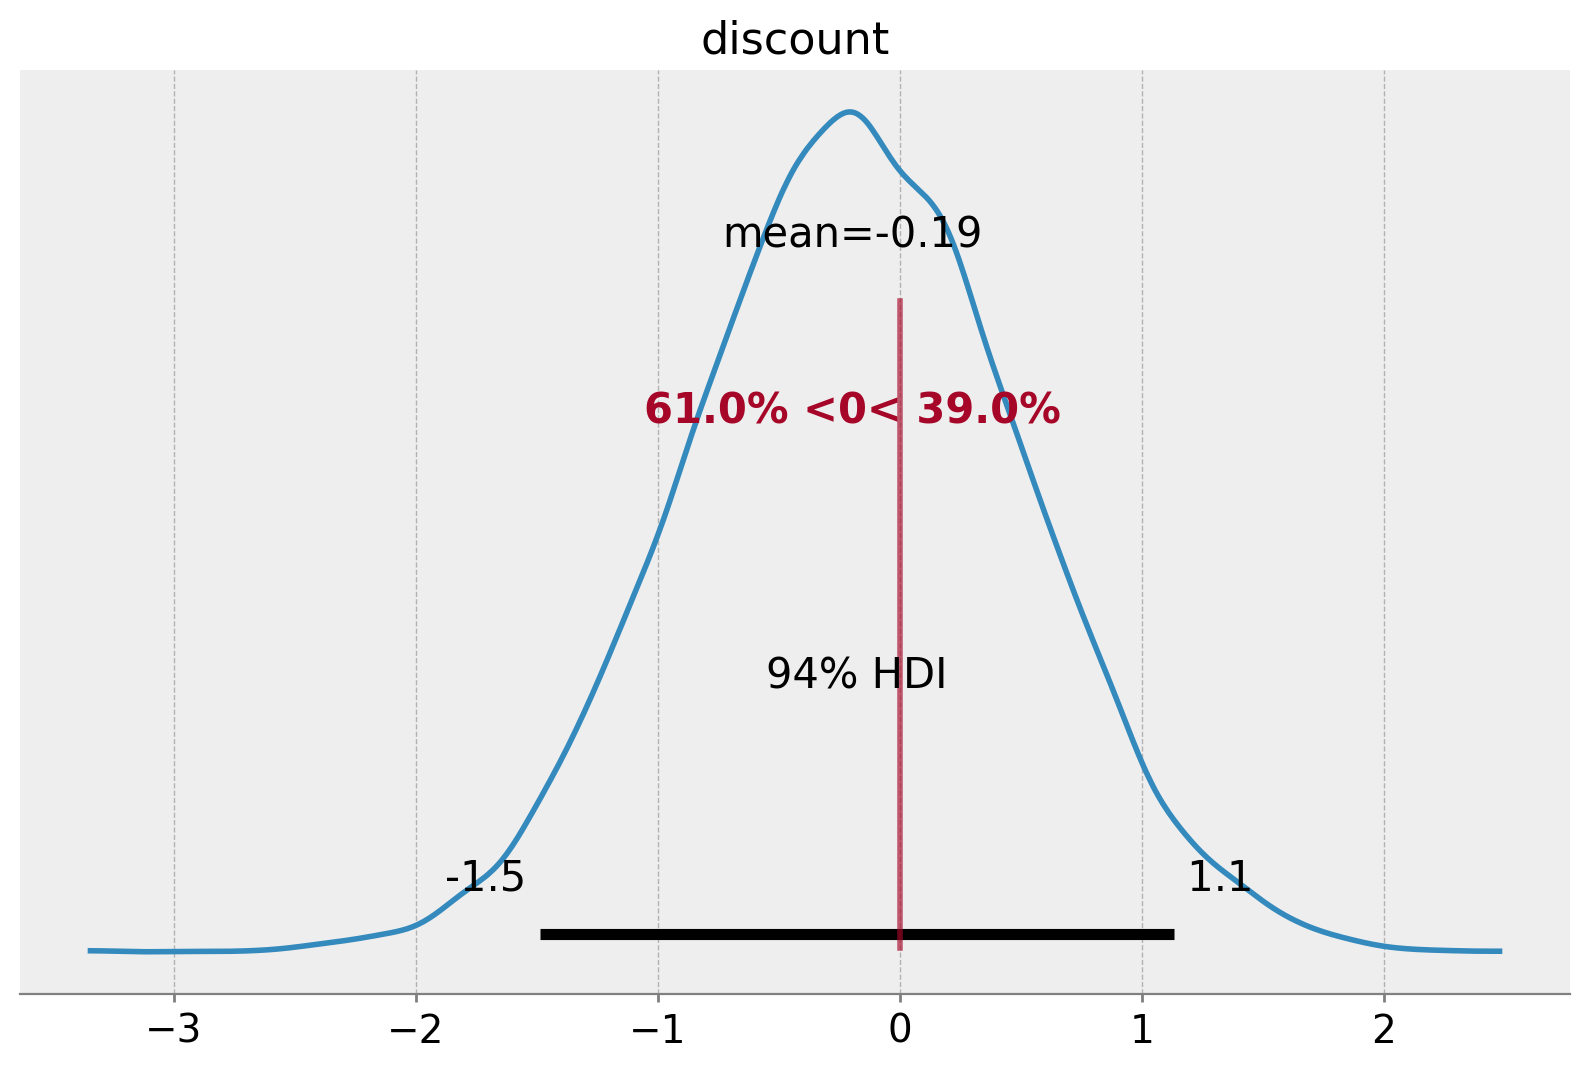

In [117]:
fig, ax = plt.subplots()
az.plot_posterior(data=complete_model_idata, var_names=["discount"], ref_val=0, ax=ax)


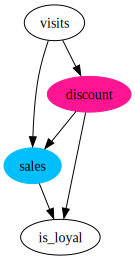

In [118]:
g = gr.Digraph()
g.node(name="sales", label="sales", color="deepskyblue", style="filled")
g.node(name="discount", label="discount", color="deeppink", style="filled")
g.edge(tail_name="discount", head_name="sales")
g.edge(tail_name="visits", head_name="discount")
g.edge(tail_name="visits", head_name="sales")
g.edge(tail_name="discount", head_name="is_loyal")
g.edge(tail_name="sales", head_name="is_loyal")
g

In [119]:
causal_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=10, sigma=3),
    "visits": bmb.Prior("Normal", mu=1, sigma=3),
    "discount": bmb.Prior("Normal", mu=0, sigma=3),
    "sigma": bmb.Prior("Exponential", lam=1 / 3),
}

causal_model = bmb.Model(
    formula="sales ~ discount + visits",
    data=data,
    family="gaussian",
    link="identity",
    priors=causal_model_priors,
)

causal_model


       Formula: sales ~ discount + visits
        Family: gaussian
          Link: mu = identity
  Observations: 700
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 10.0, sigma: 3.0)
            discount ~ Normal(mu: 0.0, sigma: 3.0)
            visits ~ Normal(mu: 1.0, sigma: 3.0)
        
        Auxiliary parameters
            sales_sigma ~ Exponential(lam: 0.3333)

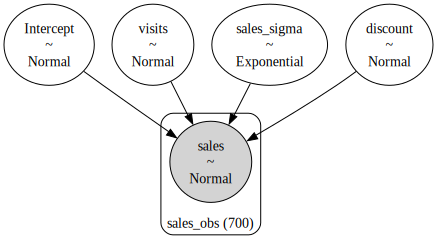

In [120]:
causal_model.build()
causal_model.graph()

In [121]:
causal_model_idata = causal_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.869189
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:04.633623
Transforming variables...
Transformation time =  0:00:00.011624


In [122]:
az.summary(data=causal_model_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.985,0.304,0.421,1.561,0.002,0.001,23907.0,16358.0,1.0
discount,1.850,0.173,1.534,2.184,0.001,0.001,20280.0,15406.0,1.0
visits,0.804,0.014,0.776,0.831,0.000,0.000,20799.0,16049.0,1.0
sales_sigma,1.904,0.051,1.813,2.004,0.000,0.000,19583.0,14542.0,1.0


Text(0.5, 0.98, 'Causal Model - Trace')

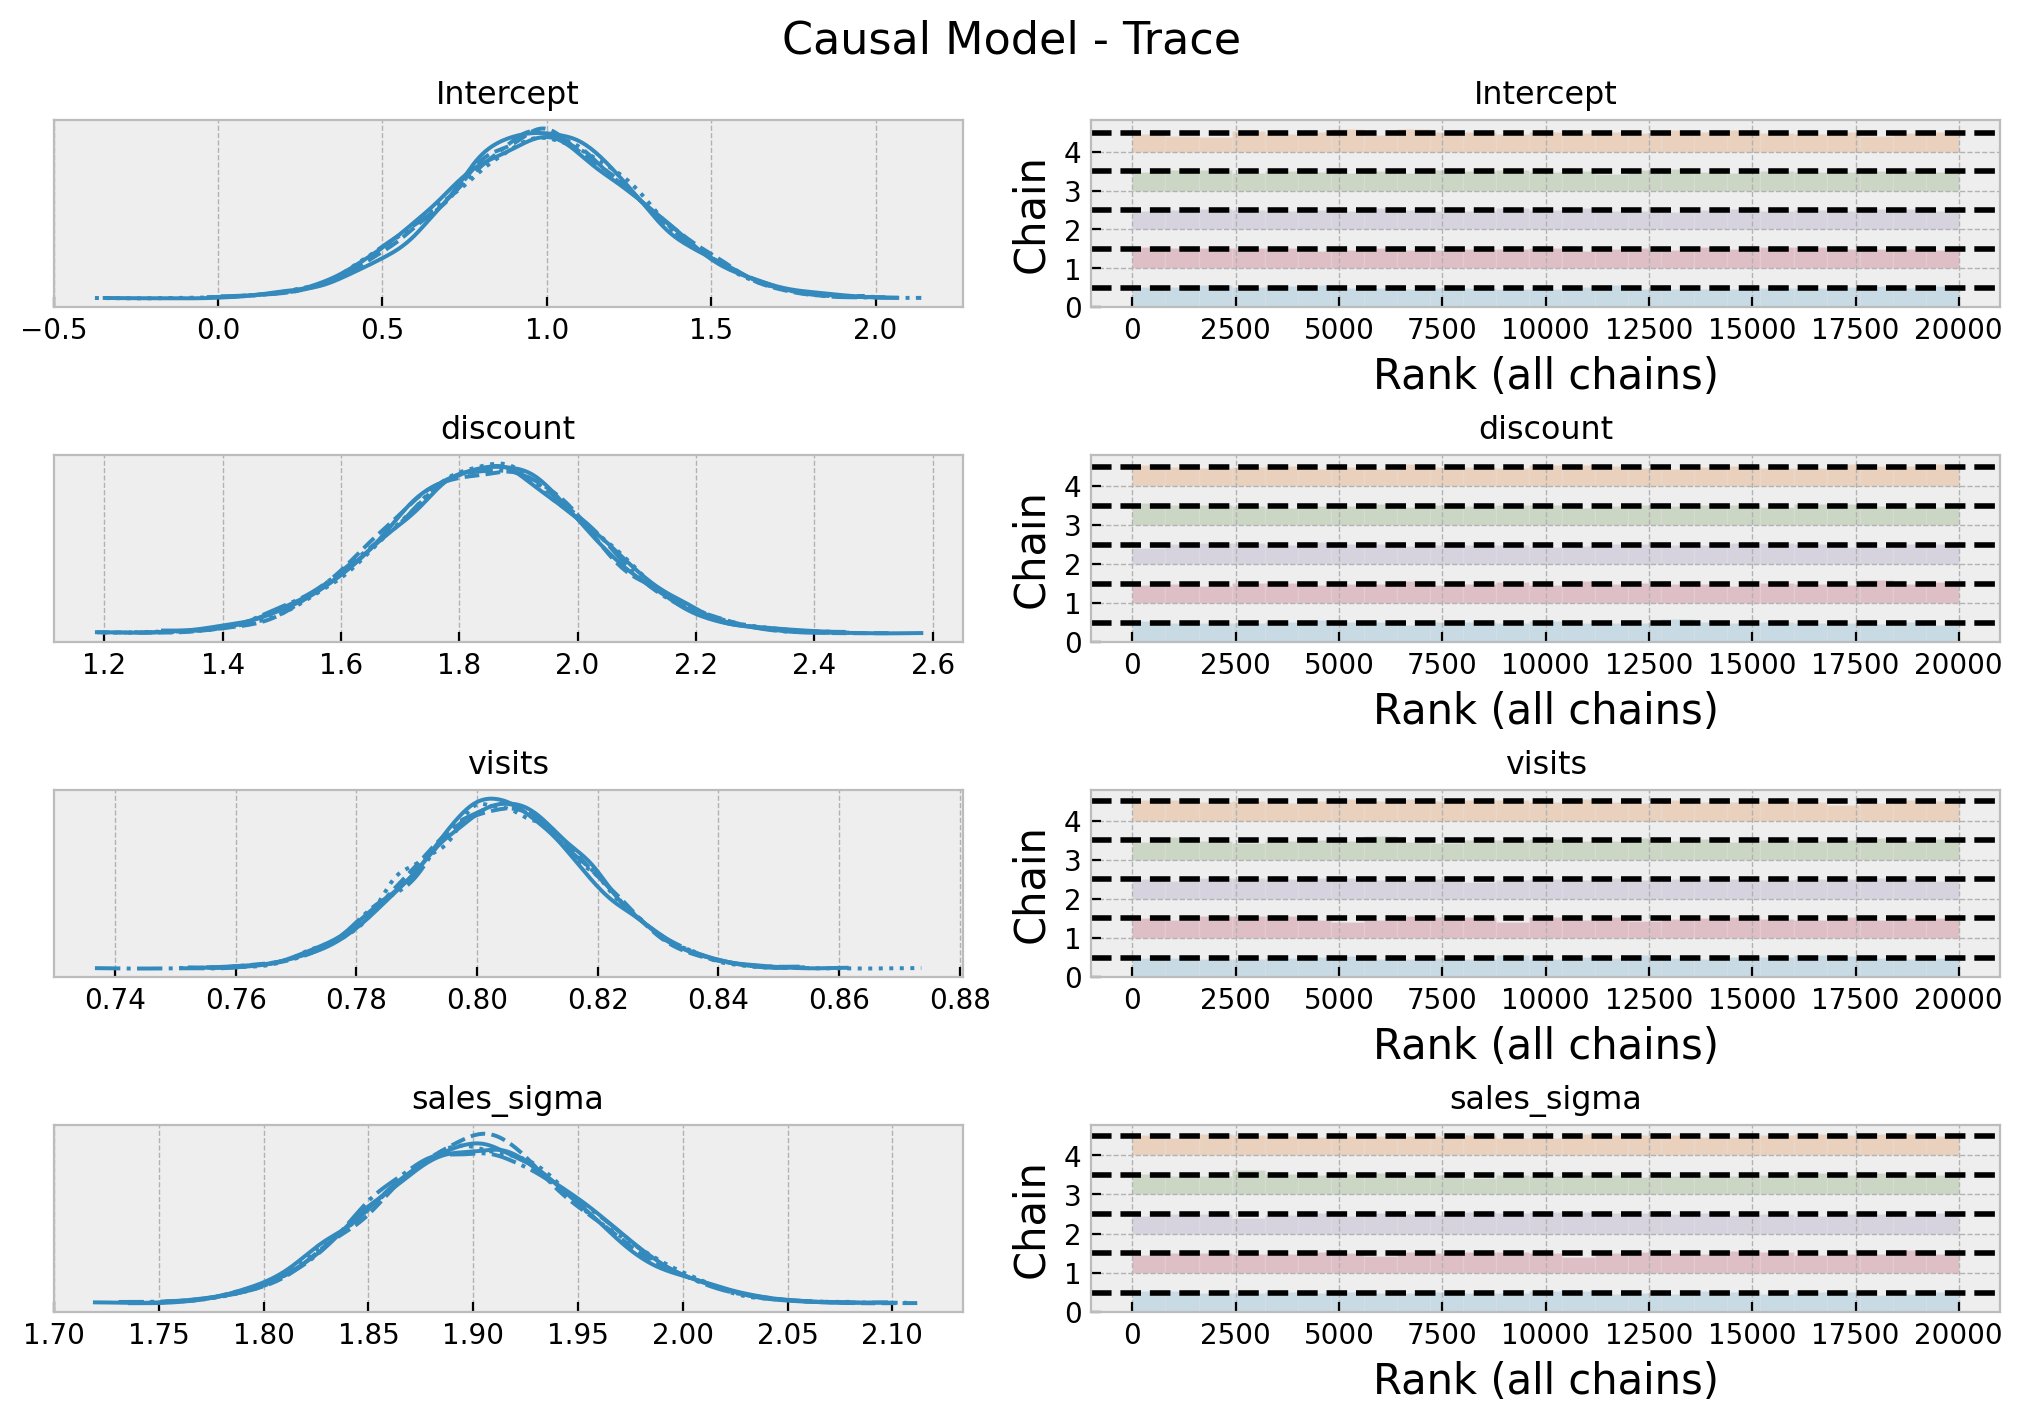

In [123]:
axes = az.plot_trace(
    data=causal_model_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Causal Model - Trace", fontsize=16)

<AxesSubplot:title={'center':'discount'}>

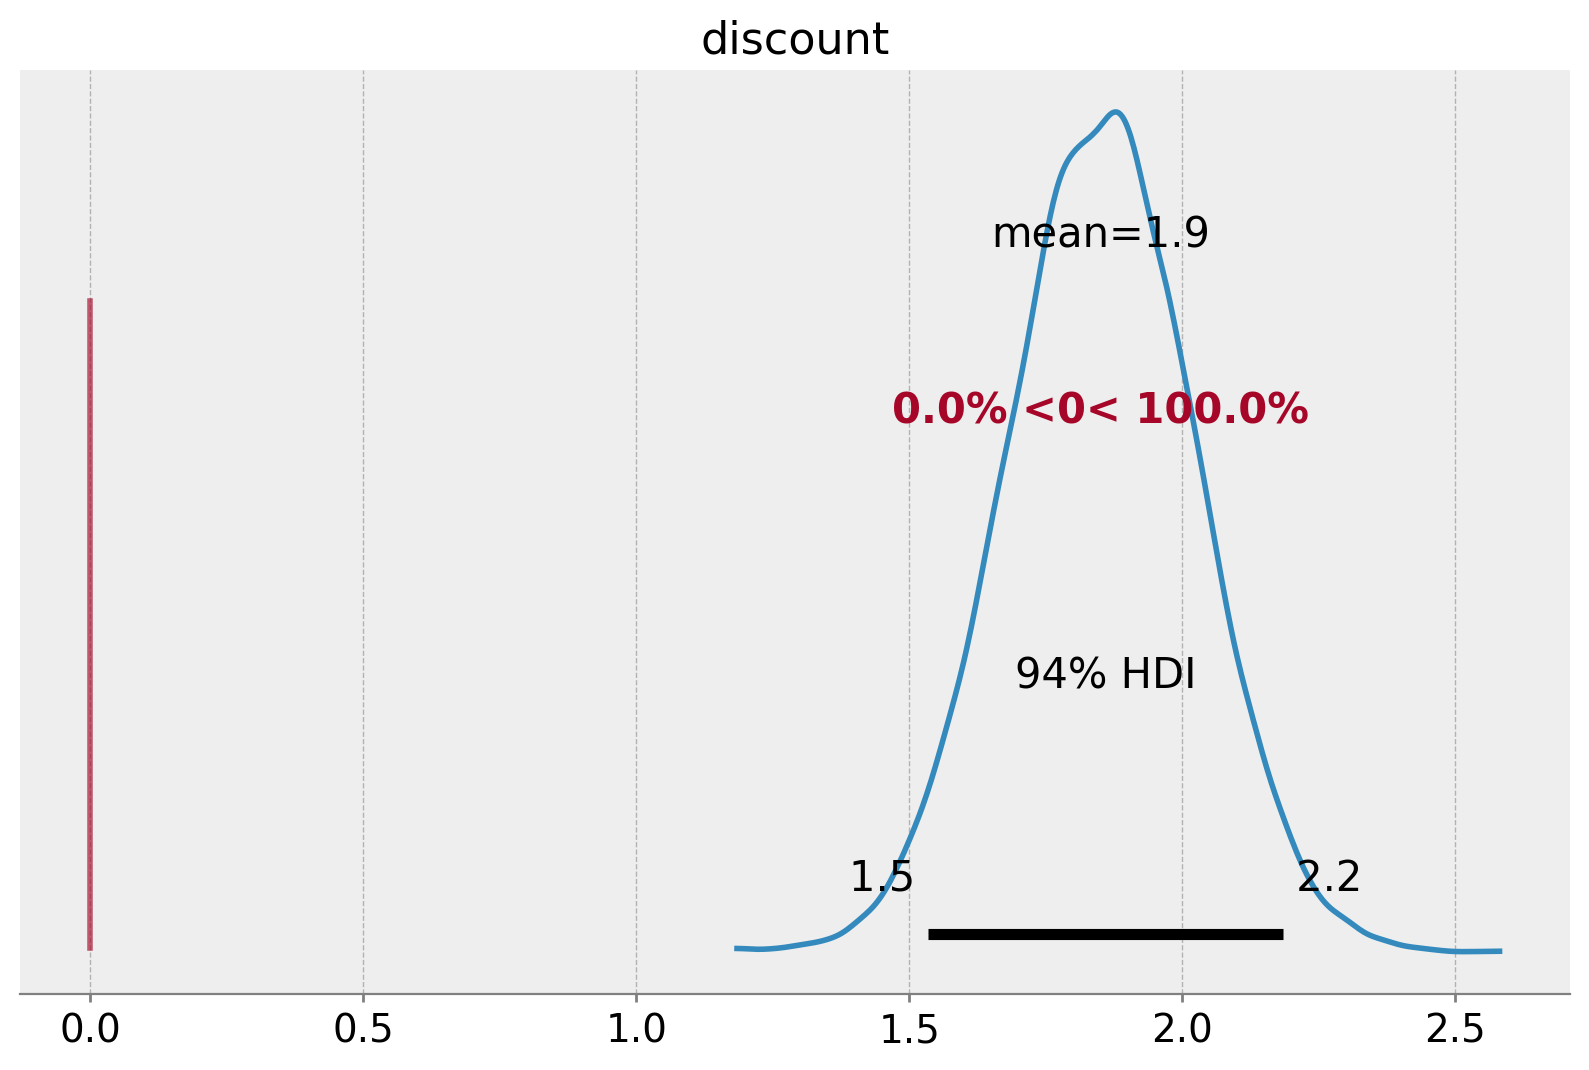

In [124]:
fig, ax = plt.subplots()
az.plot_posterior(data=causal_model_idata, var_names=["discount"], ref_val=0, ax=ax)


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

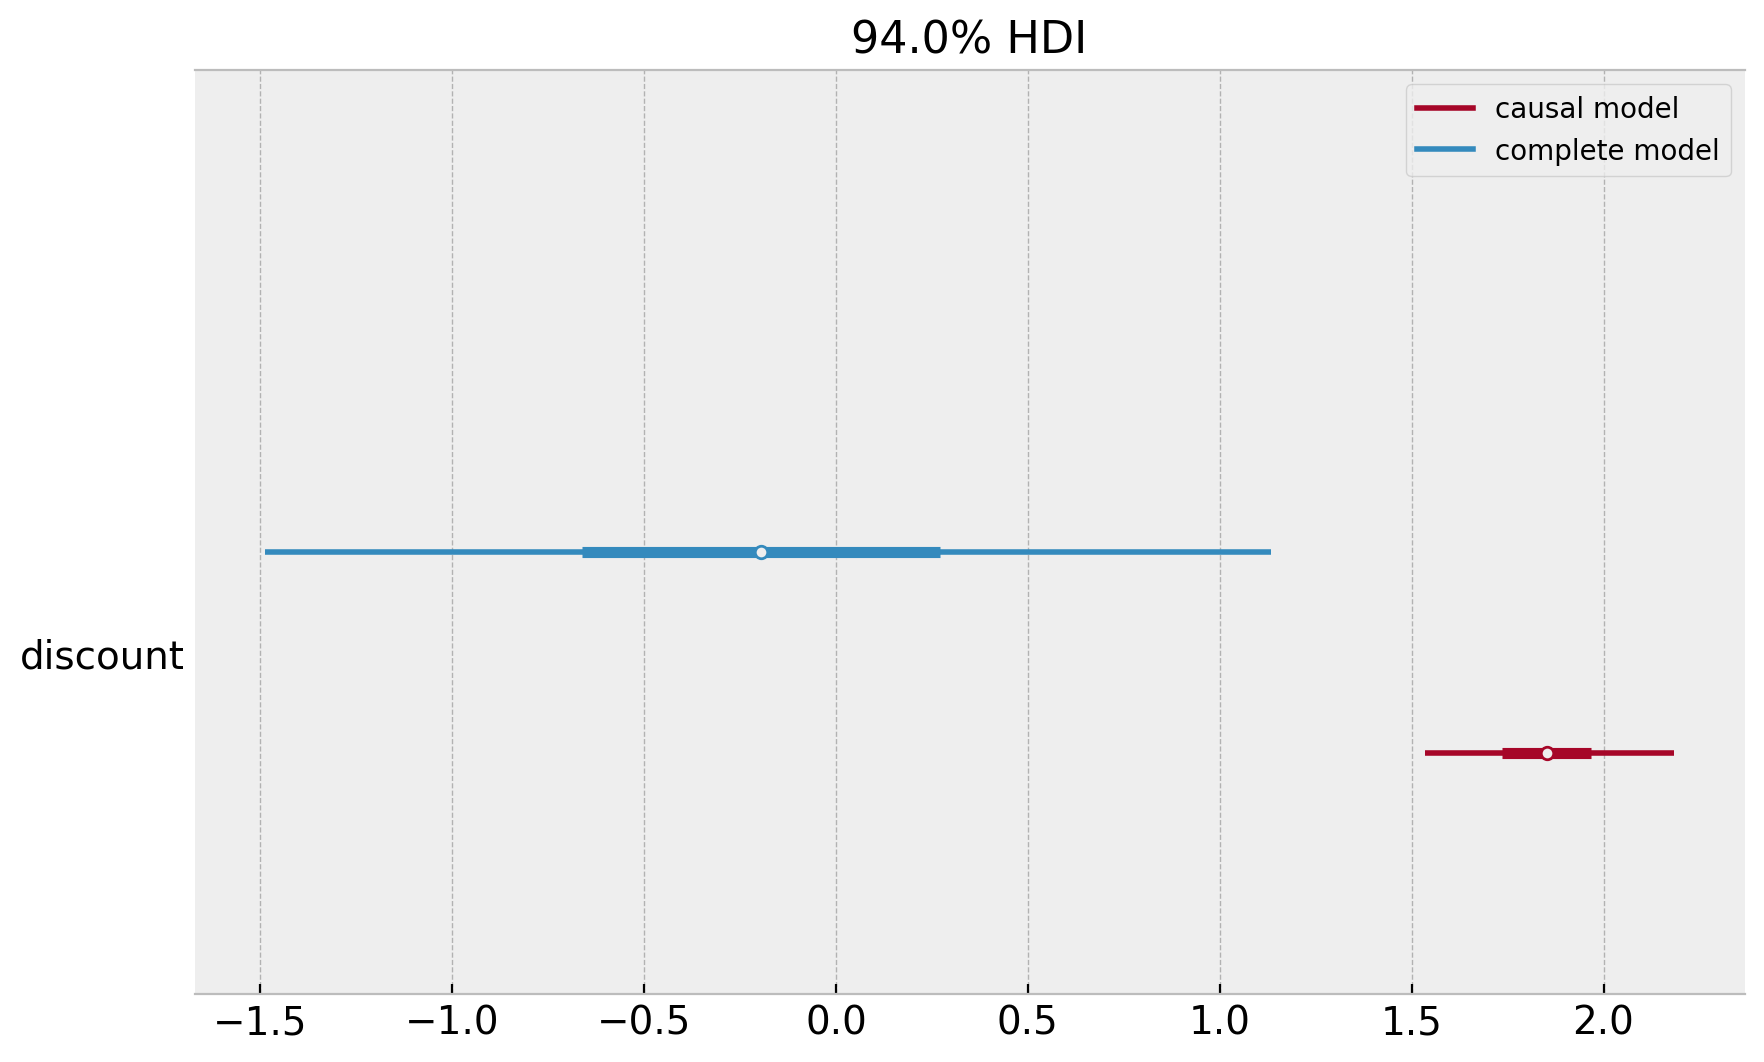

In [125]:
fig, ax = plt.subplots()


az.plot_forest(
    data=[complete_model_idata, causal_model_idata],
    var_names=["discount"],
    model_names=["complete model", "causal model"],
    combined=True,
    ax=ax,
)

[Text(0.5, 1.0, 'ML Model (Causal) - Partial Dependence Plot (Centered)')]

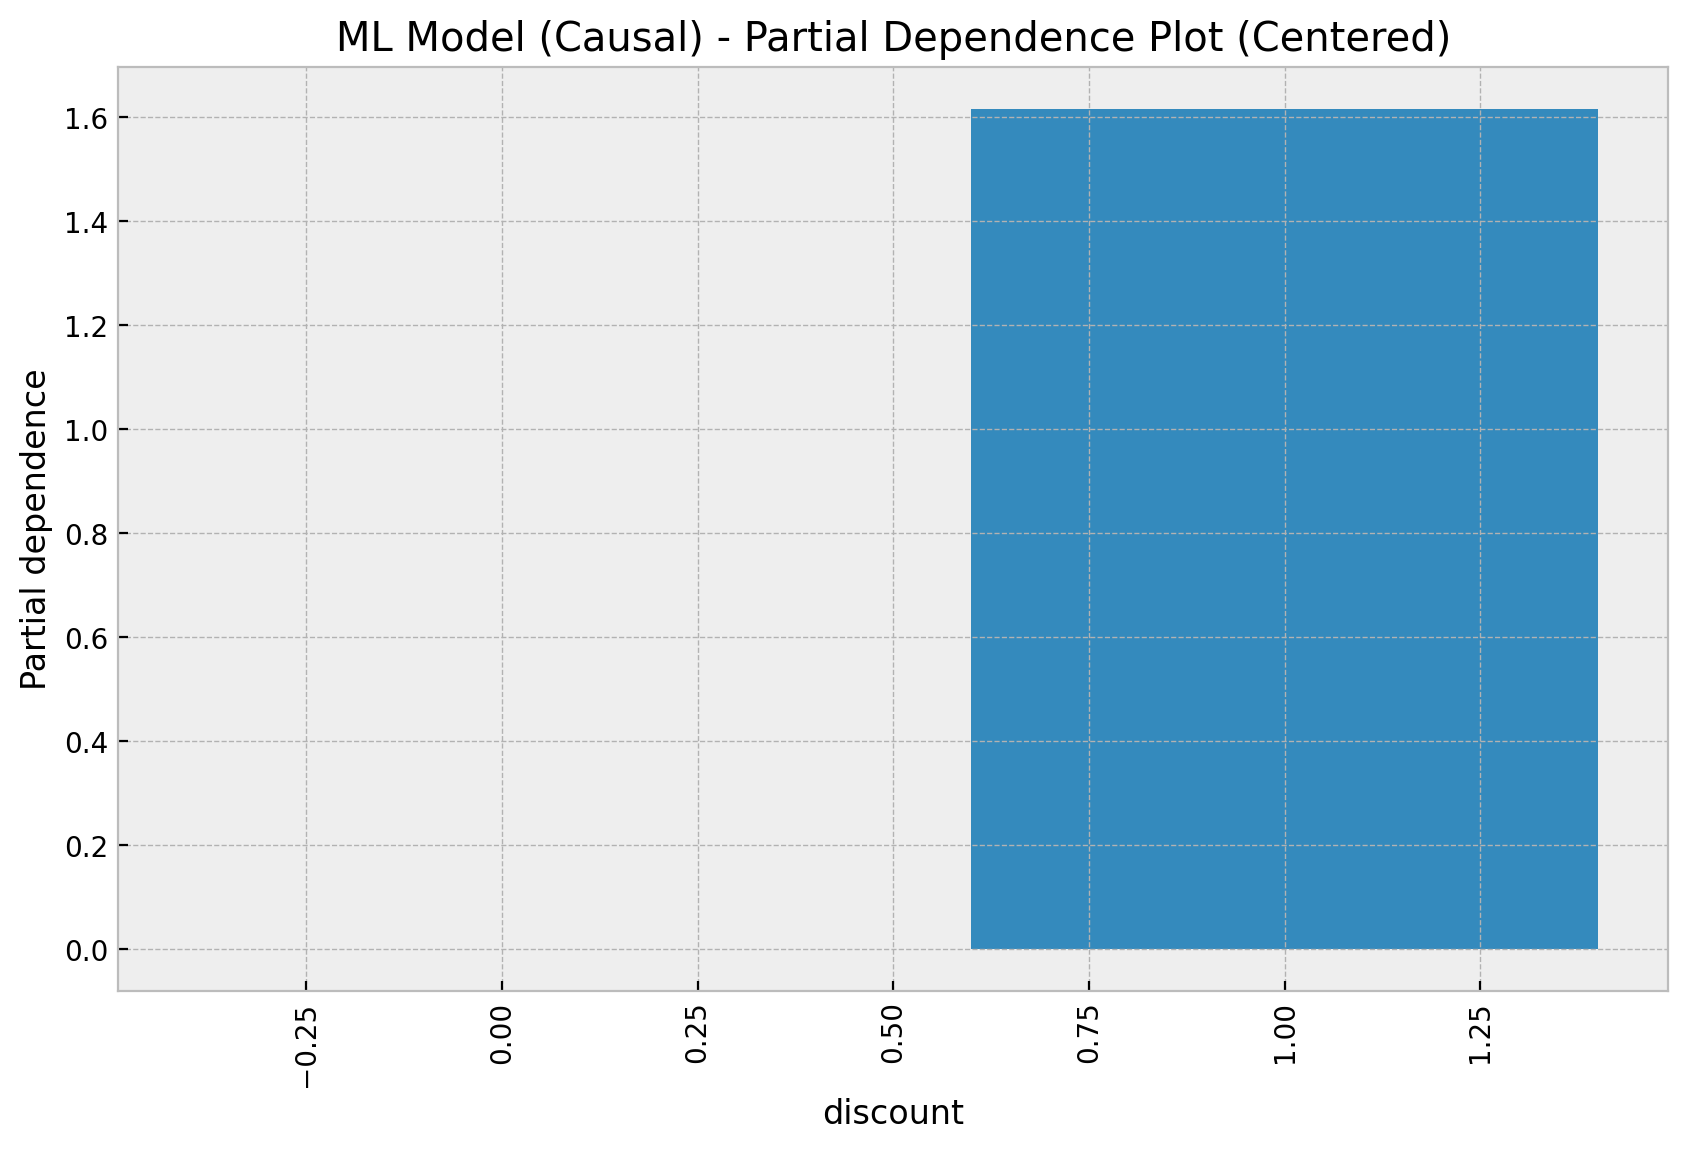

In [129]:
X_causal = X.drop(columns=["is_loyal"])

ml_model.fit(X=X_causal, y=y)

fig, ax = plt.subplots()

PartialDependenceDisplay.from_estimator(
    estimator=ml_model,
    X=X_causal,
    features=["discount"],
    categorical_features=["discount"],
    centered=True,
    random_state=seed,
    ax=ax,
)
ax.set(title="ML Model (Causal) - Partial Dependence Plot (Centered)")